In [1]:
import pandas as pd
from sklearn.datasets import make_regression
import numpy as np
import os
import seaborn as sns
import pandas as pd
from math import e,sqrt
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.optimize import leastsq
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import datetime
import statistics
import math
import os
import sys
import statistics
#sys.path.append("/home/hugo/projetos-doutorado/mimo_emb_fts/src/")

from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from scipy.stats import randint as sp_randint


In [3]:
from pyFTS.common import Util
from pyFTS.benchmarks import Measures

In [4]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

In [5]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [7]:
df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/HomeC.csv', sep=',')
data = df.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
data = data.loc[0: : 10]
data = clean_dataset(data)
data = series_to_supervised_miso(data, 1, 1,'use [kW]')
data.head()

/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,use [kW](t-1),gen [kW](t-1),Dishwasher [kW](t-1),Furnace 1 [kW](t-1),Furnace 2 [kW](t-1),Home office [kW](t-1),Fridge [kW](t-1),Wine cellar [kW](t-1),Garage door [kW](t-1),Kitchen 12 [kW](t-1),...,humidity(t-1),visibility(t-1),apparentTemperature(t-1),pressure(t-1),windSpeed(t-1),windBearing(t-1),precipIntensity(t-1),dewPoint(t-1),precipProbability(t-1),use [kW](t)
10,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.585083
20,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.533817
30,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.190950
40,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.582083
50,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.837000


In [8]:
values = data.values
values.shape

(50390, 28)

In [9]:
values = data.values
train_size=int(len(values)*0.75)
test_size = int(len(values)) - train_size
print(test_size)

12598


In [10]:
data.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[:train_size].shape

(37792, 27)

In [11]:
train_X, train_y = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[:train_size], data['use [kW](t-1)'].values[:train_size]
test_X, test_y = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[train_size:], data['use [kW](t)'].values[train_size:]

# train_y.reshape(-1)
# test_y.reshape(-1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(37792, 27) (37792,) (12598, 27) (12598,)


In [12]:
# Get the number of inputs and outputs from the dataset
df_trainx = pd.DataFrame(train_X)
df_testx = pd.DataFrame(test_X)
df_trainy = pd.DataFrame(train_y)
df_original = pd.DataFrame(test_y)

In [13]:
df_original

,0
0,0.991767
1,1.544967
2,0.816783
3,1.120817
4,0.665583
...,...
12593,1.621417
12594,0.896250
12595,1.311617
12596,2.059367


## RandomizedSearchCV

In [14]:
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
# Define the hyperparameter configuration space
hyperparameters = dict(
                     estimator__C=stats.uniform(0,50),
                     estimator__kernel=['poly', 'rbf','sigmoid'],
                     estimator__epsilon=stats.uniform(0,1))
clf=SVR()
model=MultiOutputRegressor(clf)
gsc = RandomizedSearchCV(model,hyperparameters,cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1,n_iter=10)

hyperparameters_tuning = gsc.fit(df_trainx, df_trainy)
print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

tuned_model = hyperparameters_tuning.best_estimator_

Best Parameters = {'estimator__C': 49.67065635801922, 'estimator__epsilon': 0.5578392889072011, 'estimator__kernel': 'poly'}


In [15]:
hyperparameters_tuning.best_estimator_

MultiOutputRegressor(estimator=SVR(C=49.67065635801922,
                                   epsilon=0.5578392889072011, kernel='poly'))

In [16]:
y_p = tuned_model.predict(df_testx)
columns = df_original.columns
y_p = pd.DataFrame(y_p,columns=columns)
y_p

,0
0,1.277357
1,1.343890
2,1.774816
3,1.208061
4,1.442752
...,...
12593,1.434598
12594,1.863161
12595,1.269691
12596,1.622417


In [17]:
result = {
        
         "rmse": [],
         
         "mae": [],
         "r2": [],
         "mape":[]
    }
    
final_result = {
        
         "rmse": [],
         "mae": [],
         "r2": [],
         "mape":[],
         "variable":[]
}

original = df_original.values
forecast = y_p.values

mae = round(mean_absolute_error(original,forecast),3)
r2 = round(r2_score(original,forecast),3)
rmse = round(mean_squared_error(original,forecast,squared=False),3)             
mape = round(mean_absolute_percentage_error(original,forecast),3)

result["rmse"].append(rmse)
result["mae"].append(mae)
result["r2"].append(r2)
result["mape"].append(mape)
        
measures = pd.DataFrame(result)
measures

,rmse,mae,r2,mape
0,0.686,0.556,-0.169,4.061


## MinMaxScaler

In [18]:
from sklearn.preprocessing import MinMaxScaler


In [19]:
df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/HomeC.csv', sep=',')
data = df.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
data = data.loc[0: : 10]
data = clean_dataset(data)
data = series_to_supervised_miso(data, 1, 1,'use [kW]')
values = data.values

/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [20]:
data.head()

,use [kW](t-1),gen [kW](t-1),Dishwasher [kW](t-1),Furnace 1 [kW](t-1),Furnace 2 [kW](t-1),Home office [kW](t-1),Fridge [kW](t-1),Wine cellar [kW](t-1),Garage door [kW](t-1),Kitchen 12 [kW](t-1),...,humidity(t-1),visibility(t-1),apparentTemperature(t-1),pressure(t-1),windSpeed(t-1),windBearing(t-1),precipIntensity(t-1),dewPoint(t-1),precipProbability(t-1),use [kW](t)
10,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.585083
20,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.533817
30,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.190950
40,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.582083
50,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.837000


In [27]:
cols = data.columns
list_cols = list(cols)

In [21]:
train_X, train_y = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[:train_size], data['use [kW](t-1)'].values[:train_size]
test_X, test_y = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[train_size:], data['use [kW](t)'].values[train_size:]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(37792, 27) (37792,) (12598, 27) (12598,)


In [22]:
test_y

array([0.99176667, 1.54496667, 0.81678333, ..., 1.31161667, 2.05936667,
       1.52258333])

In [23]:
from sklearn.preprocessing import MinMaxScaler
scalerx = MinMaxScaler()
scalery = MinMaxScaler()

In [24]:
# # Get the number of inputs and outputs from the dataset
df_trainx = pd.DataFrame(train_X)
df_testx = pd.DataFrame(test_X)
df_trainy = pd.DataFrame(train_y)
df_original = pd.DataFrame(test_y)

In [25]:
df_original

,0
0,0.991767
1,1.544967
2,0.816783
3,1.120817
4,0.665583
...,...
12593,1.621417
12594,0.896250
12595,1.311617
12596,2.059367


In [26]:
df_trainx_scaled = scalerx.fit_transform(df_trainx)
df_testx_scaled = scalerx.transform(df_testx)
df_trainy_scaled = scalery.fit_transform(df_trainy)


In [27]:
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
# Define the hyperparameter configuration space
hyperparameters = dict(
                     estimator__C=stats.uniform(0,50),
                     estimator__kernel=['poly', 'rbf','sigmoid'],
                     estimator__epsilon=stats.uniform(0,1))
clf=SVR()
model=MultiOutputRegressor(clf)
gsc = RandomizedSearchCV(model,hyperparameters,cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1,n_iter=10)

hyperparameters_tuning_nor = gsc.fit(df_trainx_scaled, df_trainy_scaled)
print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

tuned_model = hyperparameters_tuning_nor.best_estimator_

Best Parameters = {'estimator__C': 49.67065635801922, 'estimator__epsilon': 0.5578392889072011, 'estimator__kernel': 'poly'}


In [28]:
hyperparameters_tuning_nor.best_estimator_

MultiOutputRegressor(estimator=SVR(C=26.54560264677215,
                                   epsilon=0.030194790122402004))

In [29]:
y_p = tuned_model.predict(df_testx_scaled)
columns = df_original.columns
y_p = pd.DataFrame(y_p,columns=columns)
y_p

,0
0,0.061966
1,0.065899
2,0.110890
3,0.054308
4,0.076686
...,...
12593,0.060253
12594,0.115638
12595,0.074327
12596,0.088227


In [30]:
y_p_inv = scalery.inverse_transform(y_p)
columns = df_original.columns
y_p_inv = pd.DataFrame(y_p_inv,columns=columns)
y_p_inv

,0
0,0.794386
1,0.844807
2,1.421548
3,0.696217
4,0.983077
...,...
12593,0.772419
12594,1.482419
12595,0.952844
12596,1.131030


In [31]:
df_original

,0
0,0.991767
1,1.544967
2,0.816783
3,1.120817
4,0.665583
...,...
12593,1.621417
12594,0.896250
12595,1.311617
12596,2.059367


In [32]:
result = {
        
         "rmse": [],  
         "mae": [],
         "r2": [],
         "mape":[]
    }
    
final_result = {
        
         "rmse": [],
         
         "mae": [],
         "r2": [],
         "mape":[]
    }
 
original = df_original.values
forecast = y_p_inv.values
mae = round(mean_absolute_error(original,forecast),3)
r2 = round(r2_score(original,forecast),3)
rmse = round(mean_squared_error(original,forecast,squared=False),3)             
mape = round(mean_absolute_percentage_error(original,forecast),3)

result["rmse"].append(rmse)
result["mae"].append(mae)
result["r2"].append(r2)
result["mape"].append(mape)
        
measures = pd.DataFrame(result)
measures 

,rmse,mae,r2,mape
0,0.609,0.37,0.081,1.253


# Model Design SVR

In [56]:
def create_and_fit_model(X_train,y_train):
    MultiOutputRegressor(estimator=SVR(C=49.67065635801922,epsilon=0.5578392889072011, kernel='poly'))
    #MultiOutputRegressor(estimator=SVR(C=26.54560264677215,epsilon=0.030194790122402004))
    clf.fit(X_train, y_train)
    return clf

In [57]:
def forecast_model(clf, X_test):
    forecast = clf.predict(X_test)
    return forecast

In [58]:
def sliding_window(data,n_windows,train_size):

    result = {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape":[],
         "nrmse": []
    }
    
    final_result = {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape":[],
         "nrmse": []
    }

    tam = len(data)
    windows_length = math.floor(tam / n_windows)
    for ct, ttrain, ttest in Util.sliding_window(data, windows_length, train_size, inc=1):
        if len(ttest) > 0:
            
            print('-' * 20)
            print(f'training window {(ct)}')
            
#             scaler = StandardScaler()
#             scalery = StandardScaler()

            
            Xtrain = ttrain.loc[:,'gen [kW](t-1)':'precipProbability(t-1)']
            ytrain = ttrain.loc[:,'use [kW](t-1)']
            Xtest = ttest.loc[:,'gen [kW](t-1)':'precipProbability(t-1)']
            ytest = ttest.loc[:,'use [kW](t)']
            
#             Xtrain = scaler.fit_transform(ttrain.loc[:,'gen [kW](t-1)':'precipProbability(t-1)'])
#             ytrain = scalery.fit_transform(ttrain['use [kW](t-1)'].values.reshape(-1, 1))
#             Xtest = scaler.transform(ttest.loc[:,'gen [kW](t-1)':'precipProbability(t-1)'])
#             ytest = scalery.transform(ttest['use [kW](t)'].values.reshape(-1, 1))
            
            
            model = create_and_fit_model(Xtrain,ytrain)
            forecast = forecast_model(model, Xtest)
             
            df_forecats_columns = ['use [kW](t)']
            
            columns = list(df_forecats_columns)
            
            #prediction = scaler.inverse_transform(forecast) 
            prediction = forecast
            df_forecast = pd.DataFrame(prediction,columns=columns)
            
            #ytest_metric = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[2]))
            ytest_metric = ttest.loc[:,'use [kW](t)'].values
            df_original = pd.DataFrame(ytest_metric,columns=columns)
            
            for col in columns:  
                original = df_original[col].values
                forecast = df_forecast[col].values
#                 original = original[:len(original)-1]
#                 forecast = forecast[1:]
                
                #mae = round(mean_absolute_error(original,forecast),3)
                #r2 = round(r2_score(original,forecast),3)
                #rmse = mean_squared_error(original,forecast,squared=False)
                rmse = round(Measures.rmse(original,forecast),3)
                mape = round(Measures.mape(original,forecast),3)
                nrmse = round(cal_nrmse(rmse, original),3)
                smape = round(Measures.smape(original,forecast),3)

                result["rmse"].append(rmse)
                result["nrmse"].append(nrmse)
                result["mape"].append(mape)
                result["mae"].append(mae)
                result["smape"].append(mae)
                result["r2"].append(r2)
                result["window"].append(ct)
                
                fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
                ax.plot(original, label='Original')
                ax.plot(forecast, label='Forecast')
                handles, labels = ax.get_legend_handles_labels()
                lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
                plt.show()
        
    measures = pd.DataFrame(result)
    return measures

--------------------
training window 0


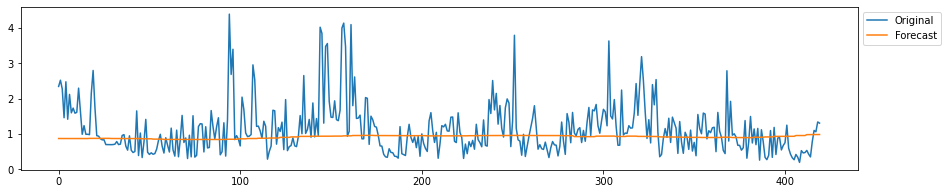

--------------------
training window 1679


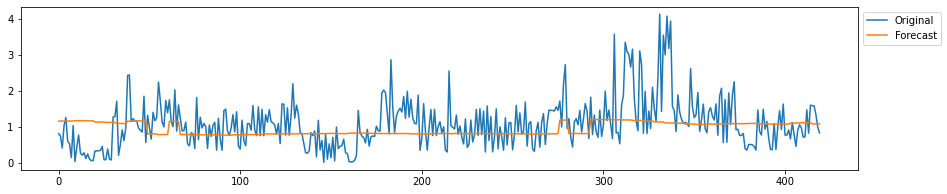

--------------------
training window 3358


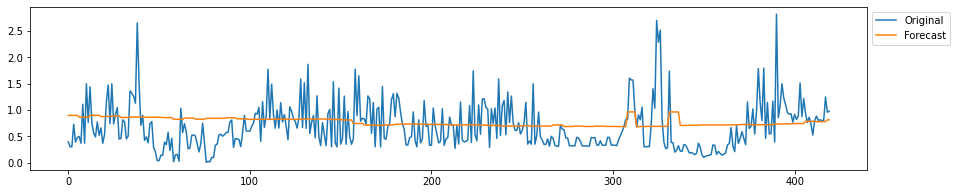

--------------------
training window 5037


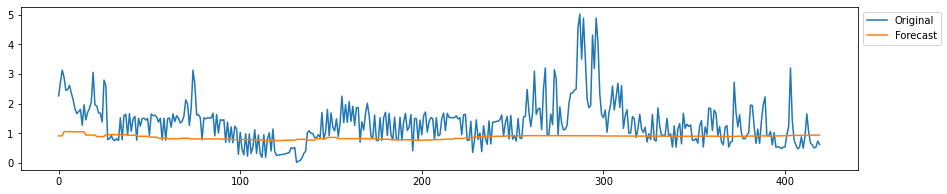

--------------------
training window 6716


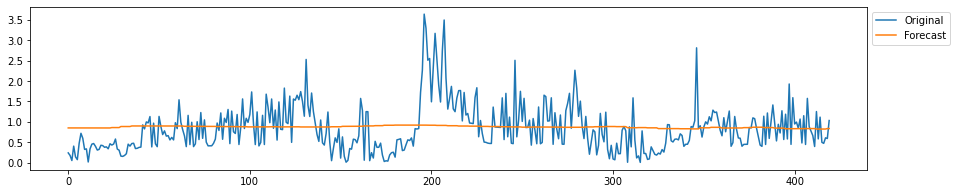

--------------------
training window 8395


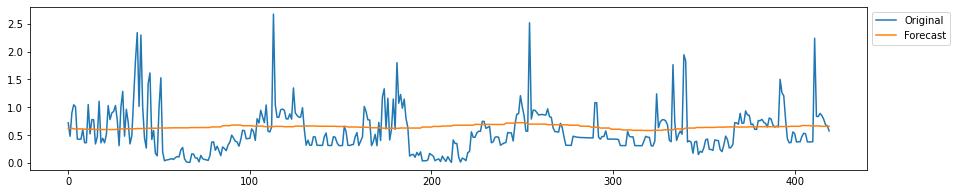

--------------------
training window 10074


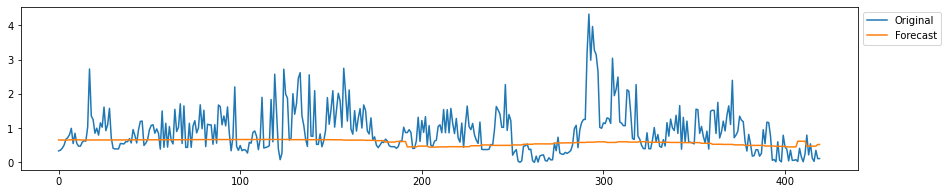

--------------------
training window 11753


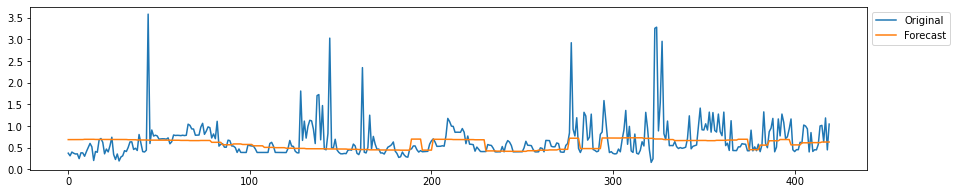

--------------------
training window 13432


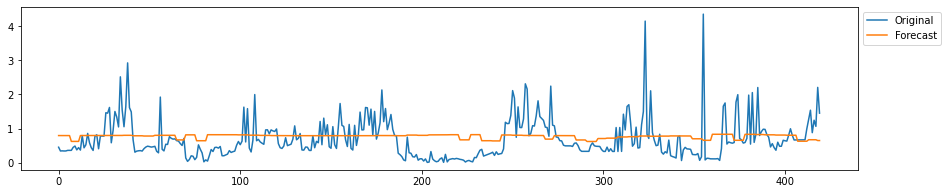

--------------------
training window 15111


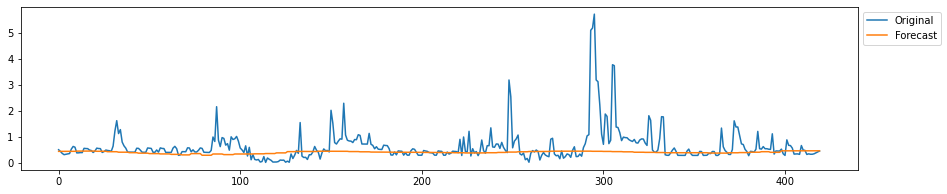

--------------------
training window 16790


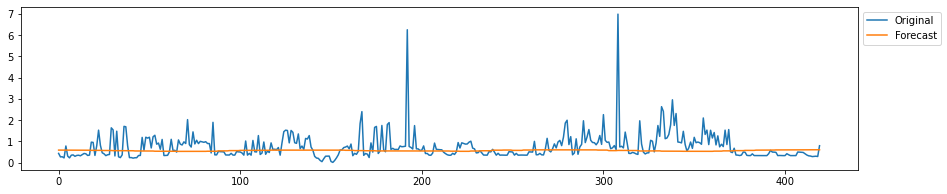

--------------------
training window 18469


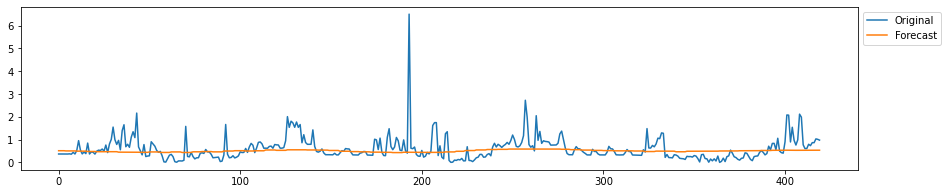

--------------------
training window 20148


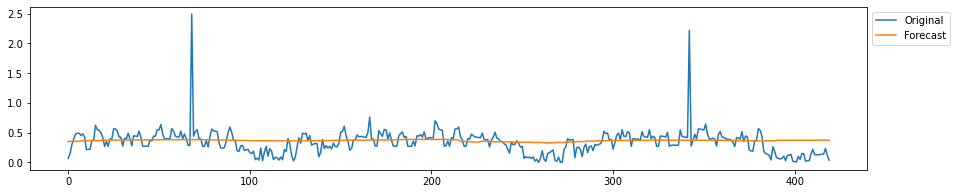

--------------------
training window 21827


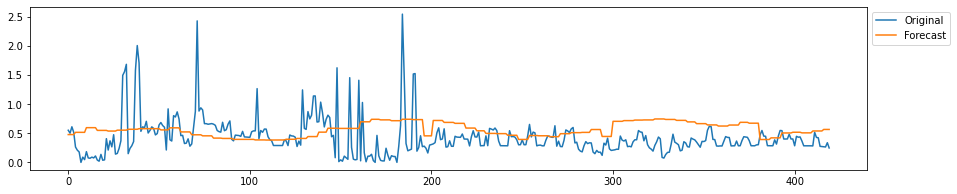

--------------------
training window 23506


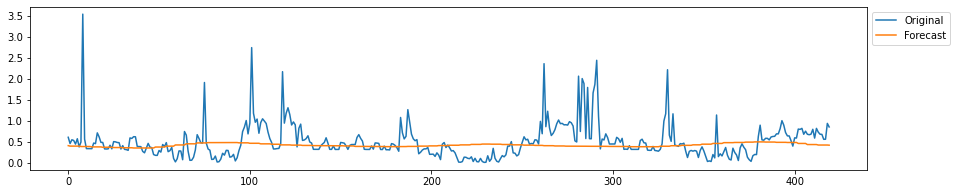

--------------------
training window 25185


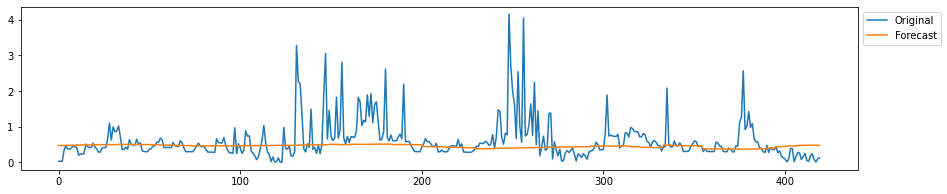

--------------------
training window 26864


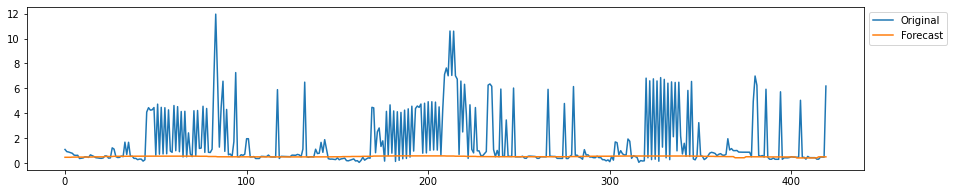

--------------------
training window 28543


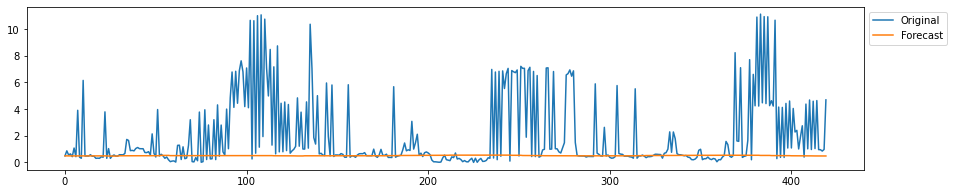

--------------------
training window 30222


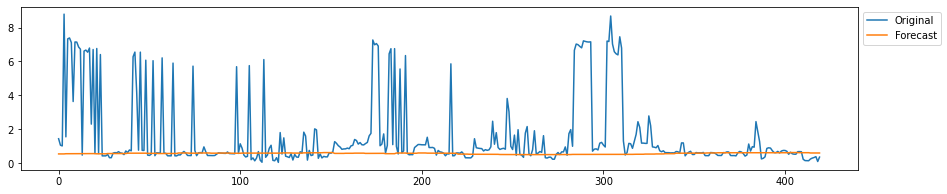

--------------------
training window 31901


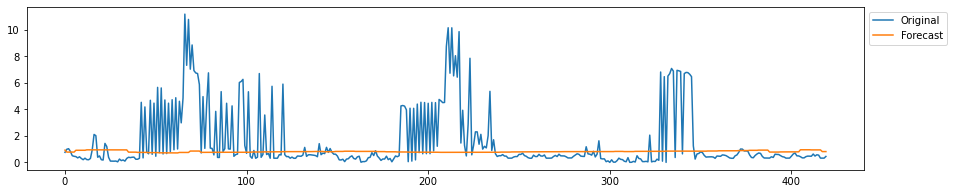

--------------------
training window 33580


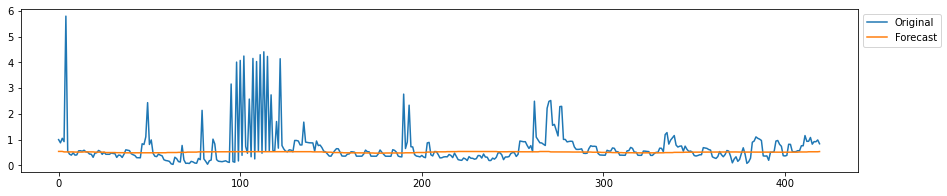

--------------------
training window 35259


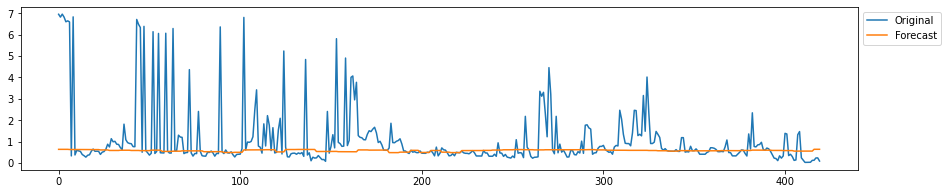

--------------------
training window 36938


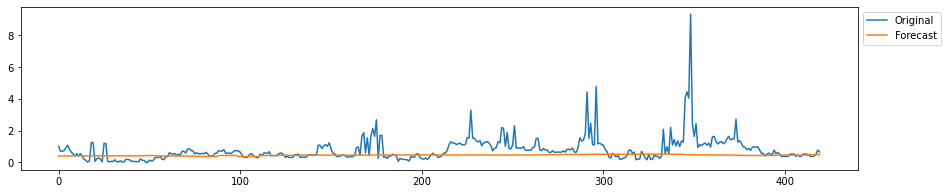

--------------------
training window 38617


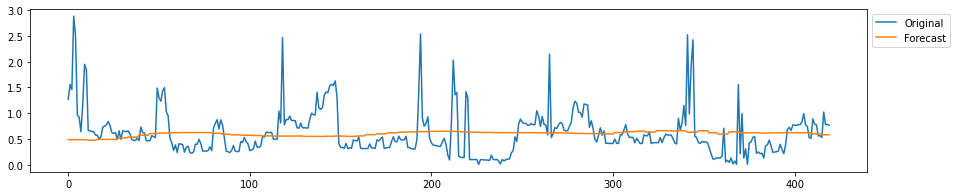

--------------------
training window 40296


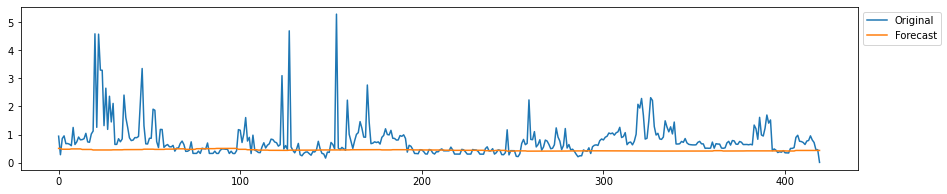

--------------------
training window 41975


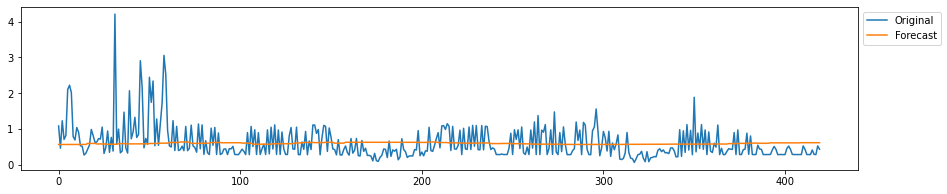

--------------------
training window 43654


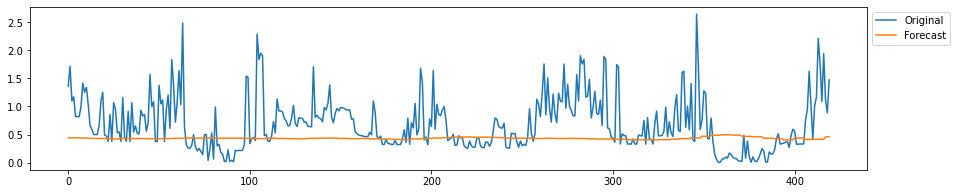

--------------------
training window 45333


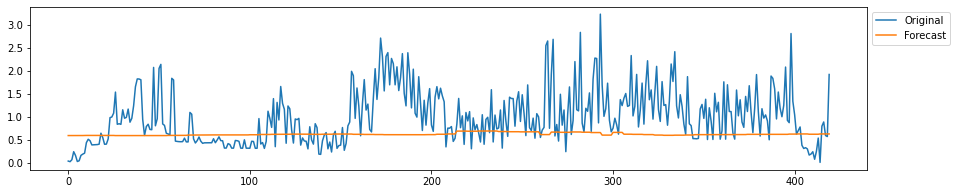

--------------------
training window 47012


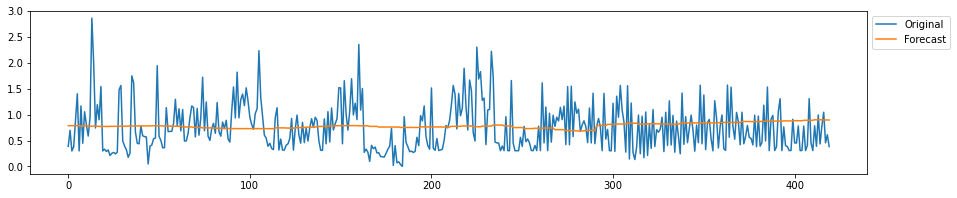

--------------------
training window 48691


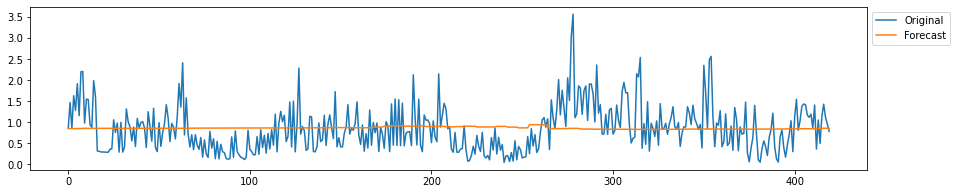

In [59]:
n_windows = 30
train_size = 0.75 

model_svr = sliding_window(data,n_windows,train_size)

In [60]:
model_svr 

,window,rmse,mape,mae,r2,smape,nrmse
0,0,0.750,50.355,0.37,0.081,0.37,0.179
1,1679,0.674,131.199,0.37,0.081,0.37,0.164
2,3358,0.450,157.715,0.37,0.081,0.37,0.160
3,5037,0.870,63.027,0.37,0.081,0.37,0.174
4,6716,0.574,214.389,0.37,0.081,0.37,0.158
5,8395,0.405,215.546,0.37,0.081,0.37,0.152
6,10074,0.714,226.488,0.37,0.081,0.37,0.165
7,11753,0.420,34.403,0.37,0.081,0.37,0.123
8,13432,0.571,250.039,0.37,0.081,0.37,0.131
9,15111,0.659,70.054,0.37,0.081,0.37,0.116


In [61]:
measures.to_csv (r'win_svr_ksh.csv', index = False, header=True)

In [62]:
measures = model_svr

In [63]:
final_result = {
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": [],
     "nrmse":[],
     "smape":[],
     "rmse_std": [],
     "mae_std": [],
     "mape_std": [],
     "smape_std": [],
     "nrmse_std": [],
     "smape_std":[]
}

final_result["rmse"].append(round(statistics.mean(measures['rmse']),3))
final_result["mape"].append(round(statistics.mean(measures['mape']),3))
final_result["smape"].append(round(statistics.mean(measures['smape']),3))
final_result["mae"].append(round(statistics.mean(measures['mae']),3))
final_result["nrmse"].append(round(statistics.mean(measures['nrmse']),3))

final_result["rmse_std"].append(round(statistics.stdev(measures['rmse']),3))
final_result["mape_std"].append(round(statistics.stdev(measures['mape']),3))
final_result["smape_std"].append(round(statistics.stdev(measures['smape']),3))
final_result["mae_std"].append(round(statistics.stdev(measures['mae']),3))
final_result["nrmse_std"].append(round(statistics.stdev(measures['nrmse']),3))
        
final_measures = pd.DataFrame(final_result)

print("Mean Statistics SRV (test): ")
final_measures

Mean Statistics SRV (test): 


,rmse,mae,mape,smape,nrmse,rmse_std,mae_std,mape_std,smape_std,nrmse_std
0,0.863,0.37,199.726,0.37,0.157,0.709,0.0,229.481,0.0,0.049


In [64]:
final_measures.to_csv (r'svr_aec_with_std.csv', index = False, header=True)

In [ ]:
# df_forecats_columns = ['Appliances(t)', 'lights(t)', 'T1(t)', 'RH_1(t)', 'T2(t)', 'RH_2(t)',
#                                    'T3(t)', 'RH_3(t)', 'T4(t)', 'RH_4(t)', 'T5(t)', 'RH_5(t)', 'T6(t)',
#                                    'RH_6(t)', 'T7(t)', 'RH_7(t)', 'T8(t)', 'RH_8(t)', 'T9(t)', 'RH_9(t)',
#                                    'T_out(t)', 'Press_mm_hg(t)', 'RH_out(t)', 'Windspeed(t)',
#                                    'Visibility(t)', 'Tdewpoint(t)']

# columns = list(df_forecats_columns)

# final_result = {
#     "variable": [],
#     "rmse": [],
#     "mae": [],
#     "mape": [],
#     "r2": [],
#     "smape": [],
#     "nrmse": [],
#     "rmse_std": [],
#     "mae_std": [],
#     "mape_std": [],
#     "r2_std": [],
#     "smape_std": [],
#     "nrmse_std": []
# }

# model_svr.to_csv (r'all_windows_svr_uci_appliances.csv', index = False, header=True)

# measures = model_svr
# var = measures.groupby("variable")

# for col in columns:
    
#     var_agr = var.get_group(col)
           
#     rmse = round(statistics.mean(var_agr.loc[:,'rmse']),3)
#     mape = round(statistics.mean(var_agr.loc[:,'mape']),3)
#     mae = round(statistics.mean(var_agr.loc[:,'mae']),3)
#     r2 = round(statistics.mean(var_agr.loc[:,'r2']),3)
#     smape = round(statistics.mean(var_agr.loc[:,'smape']),3)
#     nrmse = round(statistics.mean(var_agr.loc[:,'nrmse']),3)
    
#     rmse_std = round(statistics.stdev(var_agr.loc[:,'rmse']),3)
#     mape_std = round(statistics.stdev(var_agr.loc[:,'mape']),3)
#     mae_std = round(statistics.stdev(var_agr.loc[:,'mae']),3)
#     r2_std = round(statistics.stdev(var_agr.loc[:,'r2']),3)
#     smape_std = round(statistics.stdev(var_agr.loc[:,'smape']),3)
#     nrmse_std = round(statistics.stdev(var_agr.loc[:,'nrmse']),3)

#     final_result["variable"].append(col)
#     final_result["rmse"].append(rmse)
#     final_result["mape"].append(mape)
#     final_result["mae"].append(mae)
#     final_result["r2"].append(r2)
#     final_result["smape"].append(smape)
#     final_result["nrmse"].append(nrmse)
    
#     final_result["rmse_std"].append(rmse_std)
#     final_result["mape_std"].append(mape_std)
#     final_result["mae_std"].append(mae_std)
#     final_result["r2_std"].append(r2_std)
#     final_result["smape_std"].append(smape_std)
#     final_result["nrmse_std"].append(nrmse_std)
        
#     #print(f'Results: {(col,rmse,mae,r2)}')
        
        
# final_measures = round(pd.DataFrame(final_result),3)

In [ ]:
#final_measures